Сергей_Варивода_566381277

# Проектное задание "Классификация изображений"

Сегодня вам предстоить помочь телекомпании FOX в обработке их контента. Как вы знаете, сериал "Симпсоны" идет на телеэкранах более 25 лет, и за это время скопилось очень много видеоматериала. Персоонажи менялись вместе с изменяющимися графическими технологиями, и Гомер Симпсон-2018 не очень похож на Гомера Симпсона-1989. В этом задании вам необходимо классифицировать персонажей, проживающих в Спрингфилде. Думаю, нет смысла представлять каждого из них в отдельности.



## Цель проекта

Обучить несколько вариантов нейросетей для классификации персонажей мультфильма "Симсоны" с целью получить наиболее эффективную модель.

### Установка зависимостей

In [1]:
!pip install -q torchviz netron onnxruntime onnxruntime-gpu onnx torchinfo

In [17]:
# we will verify that GPU is enabled for this notebook
# following should print: CUDA is available!  Training on GPU ...
#
# if it prints otherwise, then you need to enable GPU:
# from Menu > Runtime > Change Runtime Type > Hardware Accelerator > GPU

import numpy as np
import math
import pandas as pd
import pickle
import PIL
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms
import torchvision.transforms as transforms
import torchvision.models as models
import warnings

from matplotlib import colors, pyplot as plt
from multiprocessing.pool import ThreadPool
from pathlib import Path
from PIL import Image
from skimage import io
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm, trange, tqdm_notebook
from torchinfo import summary
from torchvision import datasets, models
from torchvision.models import resnet50, ResNet50_Weights, resnet101, ResNet101_Weights, resnet152, ResNet152_Weights
from torchvision.transforms import v2

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [3]:
print(PIL.__version__)

9.4.0


Функция отправки сообщений в Telegram (об окончании обучения и т.п.)<BR>
Вывод идет сюда: @gover_jupyter_bot

In [1]:
def tprint(message,verb=True):   
    import requests    # подробнее об этом: https://pythonist.ru/otpravka-soobshhenij-v-telegram-pri-pomoshhi-python/
    TOKEN = "МОЙ ТОКЕН" # Мой токен бота для уведомлений
    chat_id = "ID моего чата"                                    # Мой ID 
    url = f"https://api.telegram.org/bot{TOKEN}/sendMessage?chat_id={chat_id}&text={message}"
    requests.get(url).json() # отправка сообщения
    if verb:
        print(message)

Проверяем, работаем ли мы в google colab , либо в kaggle, либо на локальной машине

In [5]:
import os
import platform

IN_LOCAL = True
IN_KAGGLE = False
IN_COLAB = False

try: 
    import google.colab
    print("Запуск в среде Colab")
    IN_COLAB = True
    IN_LOCAL = False
    
    from google.colab import drive
    drive.mount('/content/gdrive/')    
    source_path_1       = r'/content/gdrive/My Drive/Colab Notebooks/datasets/journey-springfield'
    source_archive_path = r'/content/gdrive/My Drive/Colab Notebooks/datasets/journey-springfield.zip'    
except:
    IN_COLAB = False

    if 'KAGGLE_KERNEL_RUN_TYPE' in os.environ:
        IN_KAGGLE = True
        IN_LOCAL = False
        source_path_1       = r'./datasets/journey-springfield'
        source_archive_path = r'./datasets/journey-springfield.zip'        
        print("Запуск в среде Kaggle")
    else:
        IN_KAGGLE = False
        source_path_1       = './datasets/journey-springfield'
        source_archive_path = './datasets/journey-springfield.zip'
        print("Запуск в локальной среде")
        
host = platform.node()

Запуск в локальной среде


Проверка наличия директории где должен находиться распакованный архив с фотками.

In [6]:
if os.path.exists(source_path_1):
    print(f"Directory {source_path_1} already exists")
    print('data directory already exists')
else:
    print(f"Directory {source_path_1} doesn't exist")
    if platform.system().lower().startswith('win'):    
        print('not exists')

Directory ./datasets/journey-springfield already exists
data directory already exists


&nbsp;

Распаковка архива с фотками

In [7]:
import zipfile

if os.path.exists(source_path_1):
    print(f"Directory {source_path_1} already exists")
    print('data directory already exists')
else:
    print(f"Directory {source_path_1} doesn't exist")
    if platform.system().lower().startswith('win'):
        print(f"Windows: Trying to extract archive to path {source_archive_path}")
        if os.path.exists(source_archive_path):
            print(f"Archive {source_archive_path} found. Trying to extract")
            !powershell Expand-Archive {source_archive_path} -DestinationPath {source_path_1}

        else:
            print(f"There is no archive {source_archive_path}. Aborting")
    else:
        print(f"linux: Trying to extract archive to path {source_archive_path}")
        if os.path.exists(source_archive_path):
            print(f"Archive {source_archive_path} found. Trying to extract")
        else:
            print(f"There is no archive {source_archive_path}. Aborting")
        #!unzip -q "{source_archive_path}" "{source_path_1}"
        with zipfile.ZipFile(source_archive_path, 'r') as zip_ref:
            zip_ref.extractall(source_path_1)
        #!unzip -q /content/gdrive/MyDrive/journey-springfield.zip


Directory ./datasets/journey-springfield already exists
data directory already exists


Посмотрим начинку папки

In [8]:
if platform.system().lower().startswith('win'):
    !powershell get-childitem {source_path_1}/train 
else:
    !ls {source_path_1}/train



    Љ в «®Ј: C:\_YD\Projects\DLS\07 homework\datasets\journey-springfield\train


Mode                 LastWriteTime         Length Name                                                                 
----                 -------------         ------ ----                                                                 
d-----        09.11.2023     18:21                simpsons_dataset                                                     




In [9]:
!nvidia-smi
torch.cuda.is_available()

Mon Nov 20 13:31:51 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 528.49       Driver Version: 528.49       CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  Off |
|  0%   44C    P8    30W / 450W |    753MiB / 24564MiB |      2%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

True

В нашем тесте будет 990 картнок, для которых вам будет необходимо предсказать класс.

In [10]:
%matplotlib inline
# в sklearn не все гладко, чтобы в colab удобно выводить картинки
# мы будем игнорировать warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [36]:
# ДОБАВИМ БЛОК ДЛЯ ФИКСАЦИИ ГЕНЕРАТОРОВ СЛУЧАЙНЫХ ЧИСЕЛ
import random

def seed_everything(seed):
    
    random.seed(seed)  # Зафиксировать генератор случайных чисел в Python
    np.random.seed(seed) # Зафиксировать генератор случайных чисел NumPy
    torch.manual_seed(seed) # Зафиксировать генератор случайных чисел PyTorch для CPU
    if torch.cuda.is_available(): # Если CUDA генерирует случайные числа, то нужно зафиксировать и его        
        torch.cuda.manual_seed(seed) # Зафиксировать генератор случайных чисел PyTorch для всех GPU
        torch.cuda.manual_seed_all(seed) # Зафиксировать генератор случайных чисел PyTorch для всех GPU
        torch.backends.cudnn.deterministic = True   # Использование детерминированных алгоритмов        
        torch.backends.cudnn.benchmark = False # Отключение оптимизации, для воспроизводимости результатов

# пример использования
seed = 42
seed_everything(seed)

In [19]:
# разные режимы датасета
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

In [20]:
#определим директории с тренировочными и тестовыми файлами
TRAIN_DIR = Path(f"{source_path_1}/train/")
TEST_DIR = Path(f"{source_path_1}/testset")

In [21]:
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [22]:
train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, stratify=train_val_labels)

In [23]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/


Ниже мы исспользуем враппер над датасетом для удобной работы. Вам стоит понимать, что происходит с LabelEncoder и  с torch.Transformation.

ToTensor конвертирует  PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:
$input = \frac{input - \mu}{\text{standard deviation}} $, <br>       константы - средние и дисперсии по каналам на основе ImageNet


Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.
 Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размер (это делает метод  _prepare_sample)

In [25]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode, image_size = 224):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)

        self.label_encoder = LabelEncoder()
        self.image_size = image_size

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
       
    def __getitem__(self, index):        
        if self.mode == 'train':
            
            # Разделим преобразования, выполняемые для аугментации обучающей выборки 
            # на блоки: подготовка, нормализация, базовый, размытие, геометрические трасформации (афинные преобразования)
            transform_prepare = v2.Compose([
                v2.ToImageTensor(),
                v2.ConvertImageDtype()
            ])
            transform_normalize = v2.Compose([
                v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
            
            transform_base = v2.Compose([
                v2.RandomResizedCrop(self.image_size, antialias=True),                   
                v2.RandomHorizontalFlip(p=0.5),
                v2.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value='random')
            ])
            
            transform_blur = v2.Compose([
                v2.RandomApply([v2.GaussianBlur(kernel_size=55)], p=0.3)
            ])
            
            transform_affine = v2.Compose([
               v2.RandomApply([v2.RandomAffine(degrees=140, translate=(0.1, 0.1), scale=(0.7, 1.3))], p=0.4)
            ])
            
            x = self.load_sample(self.files[index])
            x = self._prepare_sample(x) 
            x = np.array(x / 255, dtype='float32')
                        
            x = transform_prepare(x)            
            x = transform_normalize(x)            
            x = transform_base(x)
            x = transform_affine(x)
            x = transform_blur(x)
            
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
        elif self.mode == 'val':
            transform = v2.Compose([
                v2.ToImageTensor(),
                v2.ConvertImageDtype(),
                v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                v2.Resize(self.image_size,antialias=True),
                v2.CenterCrop(self.image_size)
            ])
            x = self.load_sample(self.files[index])
            x = self._prepare_sample(x) # val
            x = np.array(x / 255, dtype='float32')            
            x = transform(x)
            
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
        else:  # test
            transform = v2.Compose([
                v2.ToImageTensor(),
                v2.ConvertImageDtype(),
                v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
            x = self.load_sample(self.files[index])
            x = self._prepare_sample(x) # test
            x = np.array(x / 255, dtype='float32')
            x = transform(x)
            return x

    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [26]:
val_dataset = SimpsonsDataset(val_files, mode='val')

Давайте посмотрим на наших героев внутри датасета.

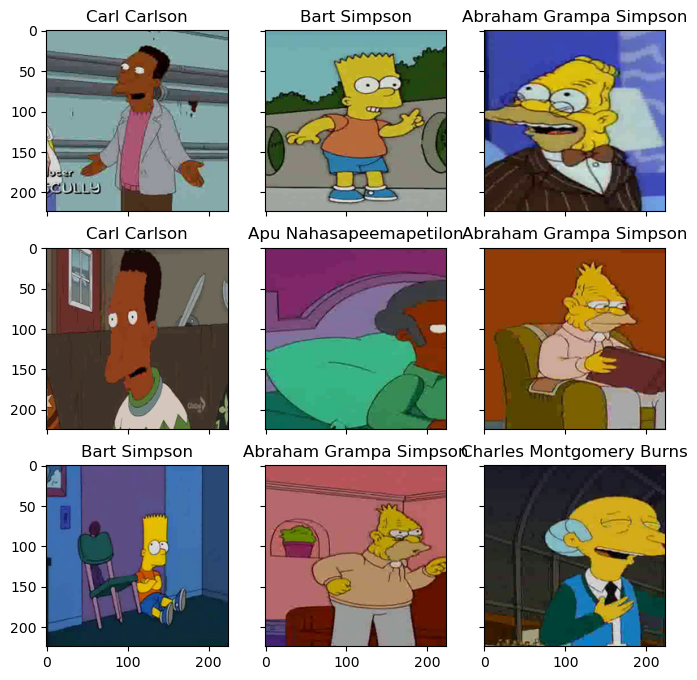

In [27]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

### Анализ аугментаций

Мы сделали настройки агументации в блоке transform-ов в классе SimpsonsDataset, но хотелось бы убедиться что они работают правильно.
Сделаем вывод аументированных картинок, оценим как это смотрится.

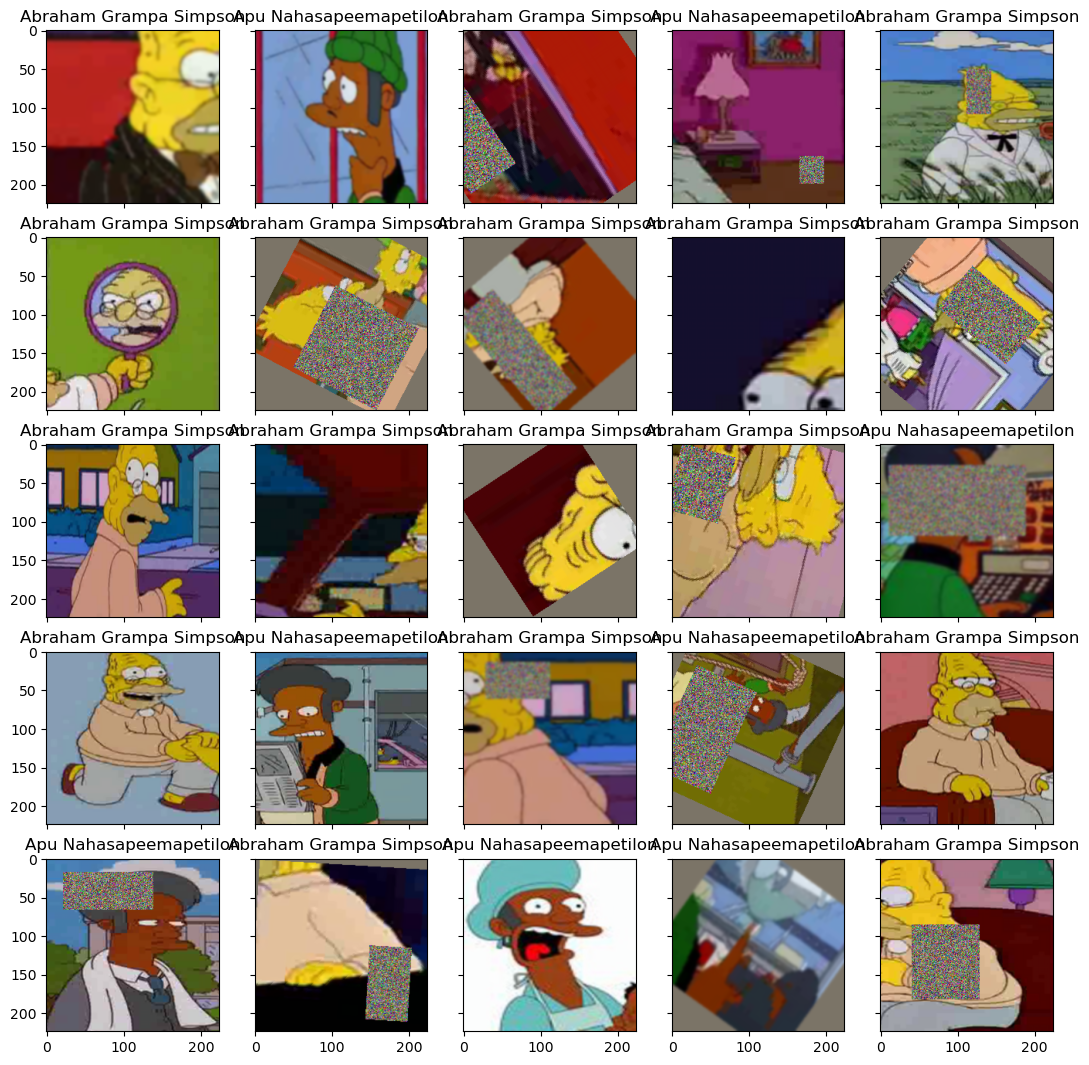

In [28]:
dataset = SimpsonsDataset(train_files, mode='train',image_size=224)
fig, ax = plt.subplots(nrows=5, ncols=5,figsize=(13, 13), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im, label = dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im.data.cpu(), \
          title=img_label,plt_ax=fig_x)

In [23]:
# uncomment if you have problem with pillow
# def register_extension(id, extension): Image.EXTENSION[extension.lower()] = id.upper()
# Image.register_extension = register_extension
# def register_extensions(id, extensions):
#     for extension in extensions: register_extension(id, extension)
# Image.register_extensions = register_extensions

### Методы для обучения и не только

In [25]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    model.train()
    
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [26]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss    = criterion(outputs, labels)
            preds   = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [28]:
def train(train_files, val_files, model, epochs, batch_size,device=DEVICE,best_metric=0,save_model=False,savename='model'): #, best_metric=0, best_wts=None):
    model = model.to(device)
    folder_for_models = "./models"
    best_wts = model.state_dict()
    
    train_loader = DataLoader(train_files, batch_size=batch_size, shuffle=True )#, pin_memory=True)#,pin_memory_device=device)
    val_loader   = DataLoader(val_files,   batch_size=batch_size, shuffle=False)#, pin_memory=True)#,pin_memory_device=device)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f} " #train_f1 {t_f1:0.4f} val_f1 {v_f1:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt       = torch.optim.Adam(model.parameters())
        #opt       = torch.optim.AdamW(model.parameters())
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            val_loss, val_acc = eval_epoch(model, val_loader, criterion) #, best_metric, best_wts)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            if val_acc > best_metric:
                best_metric = val_acc
                best_wts    = model.state_dict()
                
                state_dict_filename = f"{savename}_acc{val_acc}_cu_learn_epoch{epoch+1}.pth"
                if save_model == True:
                    if not os.path.exists(folder_for_models):
                        os.makedirs(folder_for_models)
                    torch.save(best_wts, f"./{folder_for_models}/{state_dict_filename}")

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss, v_loss=val_loss, t_acc=train_acc, v_acc=val_acc)) #, t_f1=train_f1, v_f1 = val_f1))
    return history, model.state_dict(), best_wts

In [29]:
# Добавленный метод для тренировки на модели которая 
def train_fullset(files, model, epochs, batch_size,device=DEVICE,save_model=False,savename='model'):
    model = model.to(device)
    folder_for_models = "./models"
    best_wts = model.state_dict()
    
    loader   = DataLoader(files, batch_size=batch_size, shuffle=True)

    log_template = "\nEpoch {ep:03d} loss: {t_loss:0.4f} acc {t_acc:0.4f} " 

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt       = torch.optim.Adam(model.parameters())
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            loss, acc = fit_epoch(model, loader, criterion, opt)

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=loss, t_acc=acc)) 

In [31]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []

        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [138]:
# Добавленный метод для подготовки окончательного предсказания
def make_submission(model,files,filename,image_size=224):
    model.eval()
    dataset = SimpsonsDataset(files, mode="test",image_size=image_size)
    loader = DataLoader(dataset, shuffle=False, batch_size=64)
    probs = predict(model, loader)


    preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
    filenames = [path.name for path in dataset.files]
    
    submit_df = pd.DataFrame(preds)
    submit_df['Id'] = filenames
    submit_df = submit_df.rename(columns={0:'Expected'})

    submit_df.to_csv(f"./{filename}", index=False)
    
    print(f"Submission saved to file ./{filename}")

Число классов

In [33]:
n_classes = len(np.unique(train_val_labels))
print(f"Число классов: {n_classes}")

Число классов: 42


In [34]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [35]:
def print_html(message): 
    from IPython.display import display, HTML
    out_msg = HTML(message)
    display(out_msg)

&nbsp;

&nbsp;

#### Построение нейросети


План действий:<BR>
1) дообучить ResNet152 на обучающей выборке, выгрузить результат
2) дообучить ещё, расширив обучающую выборку до всех имеющихся данных, выгрузить результат
3) дообучить Inception на обучающей выборке, выгрузить результат
4) дообучить ещё, расширив обучающую выборку до всех имеющихся данных, выгрузить результат

### ResNet 152

Из всех сетей ResNet выбираем 152 как наиболее глубокую сеть, предопожительно способную улавливать наибольшее количество информации об изображениях благодаря бОльшему числу обученных ядер в сверточных слоях.

In [34]:
val_dataset_resnet   = SimpsonsDataset(val_files,   mode='val',  image_size=224)
train_dataset_resnet = SimpsonsDataset(train_files, mode='train',image_size=224)

In [35]:
resnet = models.resnet152(weights=ResNet152_Weights.IMAGENET1K_V2)

Заменяем слой классификации

In [37]:
resn_embeds_number = resnet.fc.in_features  

# Замените классификатор на новый слой
resnet.fc = nn.Linear(resn_embeds_number, n_classes)

Посмотрим на схему сети

In [41]:
layerslist = list(resnet.children())
for i in range( len(layerslist) ):
    print_html(f"<font size=-3><B>Блок {i}</B>: {layerslist[i]}</font>")

Обучаемся

best_metric_resnet = 0
batch_size         = 96

In [43]:
#torch.load('./inception_v2.0.pth')

In [44]:
epochs_r = 40

In [ ]:
%%time
history_resnet , curr_wts_resnet, best_wts_resnet = train( train_files = train_dataset_resnet                         
                                                     , val_files   = val_dataset_resnet
                                                     , model=resnet
                                                     , epochs=epochs_r
                                                     , batch_size=batch_size
                                                     , savename = 'resnet152'
                                                     , save_model = True
                                                    ) 
tprint(f"resnet обучена на {epochs_r} эпохах")

In [46]:
loss_i, acc_i, val_loss_i, val_acc_i = zip(*history_resnet)

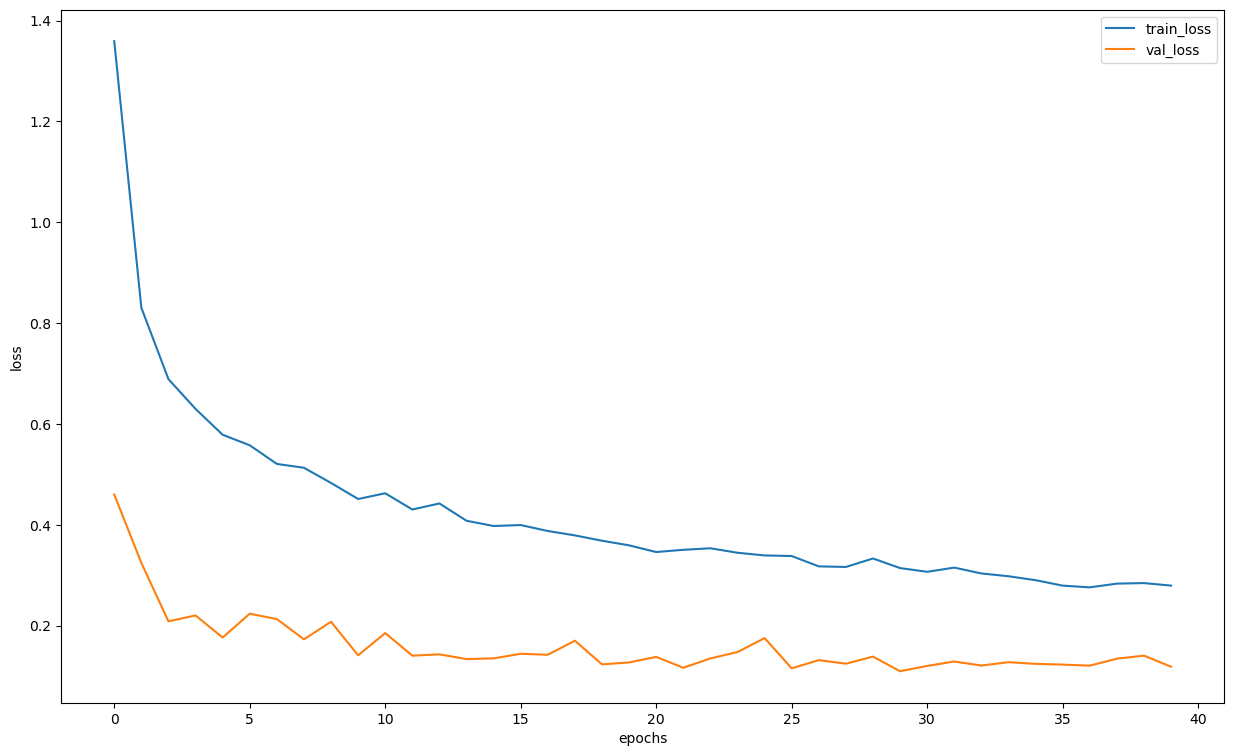

In [47]:
plt.figure(figsize=(15, 9))
plt.plot(loss_i, label="train_loss")
plt.plot(val_loss_i, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [49]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims_r = predict(resnet, imgs)

In [50]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [51]:
y_pred_r = np.argmax(probs_ims_r,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred_r]

Вычислим целевую метрику на валидационной выборке.

In [64]:
f1_r = f1_score(actual_labels, y_pred_r, average='micro')

print("F1-оценка (resnet):", f1_r)


F1-оценка (resnet): 1.0


Сделаем классную визуализацию,  чтобы посмотреть насколько сеть уверена в своих ответах. Можете исспользовать это, чтобы отлаживать правильность вывода.

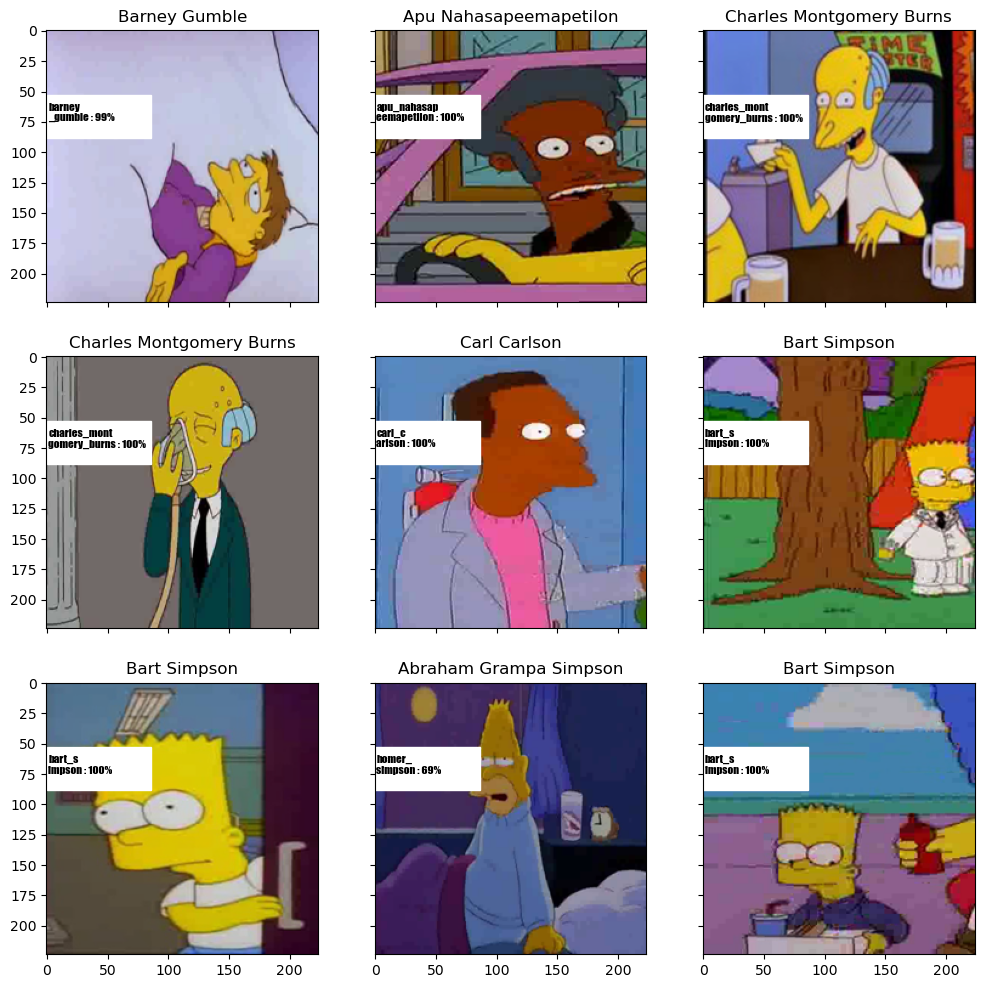

In [53]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))



    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

    actual_text = "Actual : {}".format(img_label)

    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred_resnet = predict_one_sample(resnet, im_val.unsqueeze(0))
    predicted_proba_resnet = np.max(prob_pred_resnet)*100
    y_pred_resnet = np.argmax(prob_pred_resnet)

    predicted_label_resnet = label_encoder.classes_[y_pred_resnet]
    predicted_label_resnet = predicted_label_resnet[:len(predicted_label_resnet)//2] + '\n' + predicted_label_resnet[len(predicted_label_resnet)//2:]
    predicted_text_resnet = "{} : {:.0f}%".format(predicted_label_resnet,predicted_proba_resnet)

    fig_x.text(1, 59, predicted_text_resnet , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

In [54]:
tprint(f"Предсказания сделаны, F1 = {f1_r}")

Предсказания сделаны, F1 = 1.0


#### ResNet152. Подготовка файла Submission

In [ ]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs_resnet = predict(resnet, test_loader)


preds_resnet = label_encoder.inverse_transform(np.argmax(probs_resnet, axis=1))
test_filenames = [path.name for path in test_dataset.files]


In [58]:
submit_resnet = pd.DataFrame(preds_resnet)
submit_resnet['Id'] = test_filenames
submit_resnet = submit_resnet.rename(columns={0:'Expected'})

In [60]:
submit_resnet.to_csv("./submit_resnet.csv", index=False)

In [62]:
tprint(f"Выгружено: Resnet")

Выгружено: Resnet


In [69]:
#resnet.load_state_dict(torch.load("./models/resnet152_acc0.9772640427970959_cu_learn_epoch26.pth"))

<All keys matched successfully>

<B>Промежуточный итог</B>: На данной выборке получен результат <B>0.98937</B> на тестовой выборке

#### ResNet152. Дообучение на полном датасете (train+val)

Вариант идеи улучшения метрики - дообучить модель на полной выборке (train+val), так как оптимальная архитектура уже готова.

In [ ]:
#resnet.load_state_dict(resnet_base_state_dict)

In [ ]:
# на всякий случай сохранение чекпойнта (текущего значения весов модели)
resnet_base_state_dict = resnet.state_dict()

In [82]:
full_batch_size = 96
full_epochs = 3

In [83]:
full_dataset_resnet = SimpsonsDataset(train_val_files, mode='train',image_size=224)

Дообучаемся на трёх эпохах

In [84]:
train_fullset(files=full_dataset_resnet, 
              model=resnet, 
              epochs=full_epochs, 
              batch_size=full_batch_size,
              device=DEVICE,
              save_model=False,
              savename='model') #, best_metric=0, best_wts=None):

epoch:  33%|█████████████████████████▎                                                  | 1/3 [05:14<10:28, 314.49s/it]


Epoch 001 loss: 0.3544 acc 0.9033 


epoch:  67%|██████████████████████████████████████████████████▋                         | 2/3 [10:24<05:12, 312.10s/it]


Epoch 002 loss: 0.3518 acc 0.9001 


epoch: 100%|████████████████████████████████████████████████████████████████████████████| 3/3 [15:36<00:00, 312.32s/it]


Epoch 003 loss: 0.3467 acc 0.9046 


In [85]:
tprint('ready for submission')

ready for submission


In [86]:
make_submission(resnet,test_files,"./submission_resnet152_fullset.csv")

Submission saved to file ././submission_resnet152_fullset.csv


<B>Промежуточный итог</B>: На данной выборке получен такой же результат: <B>0.98937</B> на тестовой выборке

&nbsp;

&nbsp;

### Inception

В надежде улучшить результат попробуем покрутить модель Inception

In [88]:
# Добавляем класс для инициализации весов чтобы не получать предупреждение о том что "pretrained" - устаревший аргумент
from torchvision.models.inception import Inception_V3_Weights 

In [89]:
val_dataset_inception   = SimpsonsDataset(val_files,   mode='val',  image_size=299)
train_dataset_inception = SimpsonsDataset(train_files, mode='train',image_size=299)

In [92]:
model_inception = models.inception_v3(weights = Inception_V3_Weights.IMAGENET1K_V1 )

In [94]:
# Заменяем число классов в вспомогательных "головах" (aux) и в основной "голове" на число симпсонов (n_classes)
model_inception.AuxLogits.fc = nn.Linear(768,  n_classes)
model_inception.fc           = nn.Linear(2048, n_classes)

In [97]:
model_inception.aux_logits = False
model_inception = model_inception.to(DEVICE)

Обучаемся

In [98]:
best_metric = 0
batch_size  = 64

In [99]:
#torch.load('./inception_v2.0.pth')

In [100]:
epochs_i = 30

In [101]:
%%time
history_inception, curr_wts_inception, best_wts_inception = train( train_files = train_dataset_inception
                                                             , val_files = val_dataset_inception
                                                             , model=model_inception
                                                             , epochs=epochs_i
                                                             , batch_size=batch_size
                                                             , savename = 'inceptionv4_'
                                                             , save_model = True
                                                            ) 

epoch:   3%|██▍                                                                      | 1/30 [16:24<7:55:44, 984.30s/it]


Epoch 001 train_loss: 1.8655 val_loss 1.0805 train_acc 0.5102 val_acc 0.7277 


epoch:   7%|████▊                                                                    | 2/30 [32:00<7:26:15, 956.28s/it]


Epoch 002 train_loss: 1.2060 val_loss 0.7938 train_acc 0.6823 val_acc 0.8084 


epoch:  10%|███████▎                                                                 | 3/30 [47:33<7:05:31, 945.62s/it]


Epoch 003 train_loss: 1.0277 val_loss 0.5606 train_acc 0.7284 val_acc 0.8519 


epoch:  13%|█████████▍                                                             | 4/30 [1:03:15<6:49:09, 944.20s/it]


Epoch 004 train_loss: 0.9259 val_loss 0.3999 train_acc 0.7560 val_acc 0.8987 


epoch:  17%|███████████▊                                                           | 5/30 [1:19:15<6:35:42, 949.70s/it]


Epoch 005 train_loss: 0.8395 val_loss 0.3679 train_acc 0.7769 val_acc 0.8985 


epoch:  20%|██████████████▏                                                        | 6/30 [1:35:06<6:20:03, 950.15s/it]


Epoch 006 train_loss: 0.7923 val_loss 0.3092 train_acc 0.7883 val_acc 0.9184 


epoch:  23%|████████████████▌                                                      | 7/30 [1:50:45<6:02:51, 946.60s/it]


Epoch 007 train_loss: 0.7562 val_loss 0.2487 train_acc 0.7968 val_acc 0.9348 


epoch:  27%|██████████████████▉                                                    | 8/30 [2:06:44<5:48:28, 950.41s/it]


Epoch 008 train_loss: 0.7261 val_loss 0.2634 train_acc 0.8058 val_acc 0.9278 


epoch:  30%|█████████████████████▎                                                 | 9/30 [2:22:24<5:31:34, 947.34s/it]


Epoch 009 train_loss: 0.7067 val_loss 0.2038 train_acc 0.8126 val_acc 0.9484 


epoch:  33%|███████████████████████▎                                              | 10/30 [2:37:52<5:13:46, 941.35s/it]


Epoch 010 train_loss: 0.6570 val_loss 0.1825 train_acc 0.8245 val_acc 0.9538 


epoch:  37%|█████████████████████████▋                                            | 11/30 [2:53:36<4:58:21, 942.20s/it]


Epoch 011 train_loss: 0.6533 val_loss 0.2015 train_acc 0.8246 val_acc 0.9480 


epoch:  40%|████████████████████████████                                          | 12/30 [3:09:40<4:44:34, 948.60s/it]


Epoch 012 train_loss: 0.6412 val_loss 0.2200 train_acc 0.8255 val_acc 0.9444 


epoch:  43%|██████████████████████████████▎                                       | 13/30 [3:25:33<4:29:09, 949.94s/it]


Epoch 013 train_loss: 0.6366 val_loss 0.1739 train_acc 0.8288 val_acc 0.9564 


epoch:  47%|████████████████████████████████▋                                     | 14/30 [3:40:59<4:11:25, 942.81s/it]


Epoch 014 train_loss: 0.6101 val_loss 0.1743 train_acc 0.8344 val_acc 0.9564 


epoch:  50%|███████████████████████████████████                                   | 15/30 [3:56:22<3:54:13, 936.92s/it]


Epoch 015 train_loss: 0.5878 val_loss 0.1938 train_acc 0.8392 val_acc 0.9498 


epoch:  53%|█████████████████████████████████████▎                                | 16/30 [4:12:10<3:39:21, 940.14s/it]


Epoch 016 train_loss: 0.6148 val_loss 0.1996 train_acc 0.8343 val_acc 0.9480 


epoch:  57%|███████████████████████████████████████▋                              | 17/30 [4:27:39<3:22:57, 936.74s/it]


Epoch 017 train_loss: 0.5764 val_loss 0.1723 train_acc 0.8450 val_acc 0.9585 


epoch:  60%|██████████████████████████████████████████                            | 18/30 [4:43:45<3:09:05, 945.49s/it]


Epoch 018 train_loss: 0.5618 val_loss 0.1942 train_acc 0.8480 val_acc 0.9513 


epoch:  63%|████████████████████████████████████████████▎                         | 19/30 [4:59:22<2:52:53, 943.02s/it]


Epoch 019 train_loss: 0.5627 val_loss 0.1478 train_acc 0.8476 val_acc 0.9622 


epoch:  67%|██████████████████████████████████████████████▋                       | 20/30 [5:14:57<2:36:47, 940.79s/it]


Epoch 020 train_loss: 0.5528 val_loss 0.1516 train_acc 0.8480 val_acc 0.9601 


epoch:  70%|█████████████████████████████████████████████████                     | 21/30 [5:30:51<2:21:40, 944.51s/it]


Epoch 021 train_loss: 0.5371 val_loss 0.1507 train_acc 0.8553 val_acc 0.9645 


epoch:  73%|███████████████████████████████████████████████████▎                  | 22/30 [5:46:21<2:05:22, 940.37s/it]


Epoch 022 train_loss: 0.5241 val_loss 0.1527 train_acc 0.8595 val_acc 0.9648 


epoch:  77%|█████████████████████████████████████████████████████▋                | 23/30 [6:01:21<1:48:16, 928.07s/it]


Epoch 023 train_loss: 0.5142 val_loss 0.1548 train_acc 0.8611 val_acc 0.9620 


epoch:  80%|████████████████████████████████████████████████████████              | 24/30 [6:17:08<1:33:23, 933.95s/it]


Epoch 024 train_loss: 0.5140 val_loss 0.1549 train_acc 0.8582 val_acc 0.9606 


epoch:  83%|██████████████████████████████████████████████████████████▎           | 25/30 [6:32:44<1:17:52, 934.55s/it]


Epoch 025 train_loss: 0.4945 val_loss 0.1673 train_acc 0.8668 val_acc 0.9597 


epoch:  87%|████████████████████████████████████████████████████████████▋         | 26/30 [6:48:25<1:02:25, 936.35s/it]


Epoch 026 train_loss: 0.5038 val_loss 0.1292 train_acc 0.8643 val_acc 0.9696 


epoch:  90%|████████████████████████████████████████████████████████████████▊       | 27/30 [7:03:49<46:37, 932.63s/it]


Epoch 027 train_loss: 0.5144 val_loss 0.1469 train_acc 0.8597 val_acc 0.9643 


epoch:  93%|███████████████████████████████████████████████████████████████████▏    | 28/30 [7:19:33<31:12, 936.02s/it]


Epoch 028 train_loss: 0.4836 val_loss 0.1909 train_acc 0.8676 val_acc 0.9501 


epoch:  97%|█████████████████████████████████████████████████████████████████████▌  | 29/30 [7:34:52<15:30, 930.92s/it]


Epoch 029 train_loss: 0.4698 val_loss 0.1158 train_acc 0.8718 val_acc 0.9761 


epoch: 100%|████████████████████████████████████████████████████████████████████████| 30/30 [7:50:31<00:00, 941.05s/it]


Epoch 030 train_loss: 0.4884 val_loss 0.1592 train_acc 0.8671 val_acc 0.9643 
CPU times: total: 3d 9h 11min 40s
Wall time: 7h 50min 31s


In [102]:
tprint(f"inception обучена на {epochs_i} эпохах")

inception обучена на 30 эпохах


In [104]:
loss_i, acc_i, val_loss_i, val_acc_i = zip(*history_inception)

In [105]:
#model_inception.load_state_dict(best_wts)

Сохранение дообученной модели:

In [106]:
torch.save(model_inception.state_dict(), 'inception_v4.0.pth')

In [107]:
loss_i, acc_i, val_loss_i, val_acc_i = zip(*history_inception)

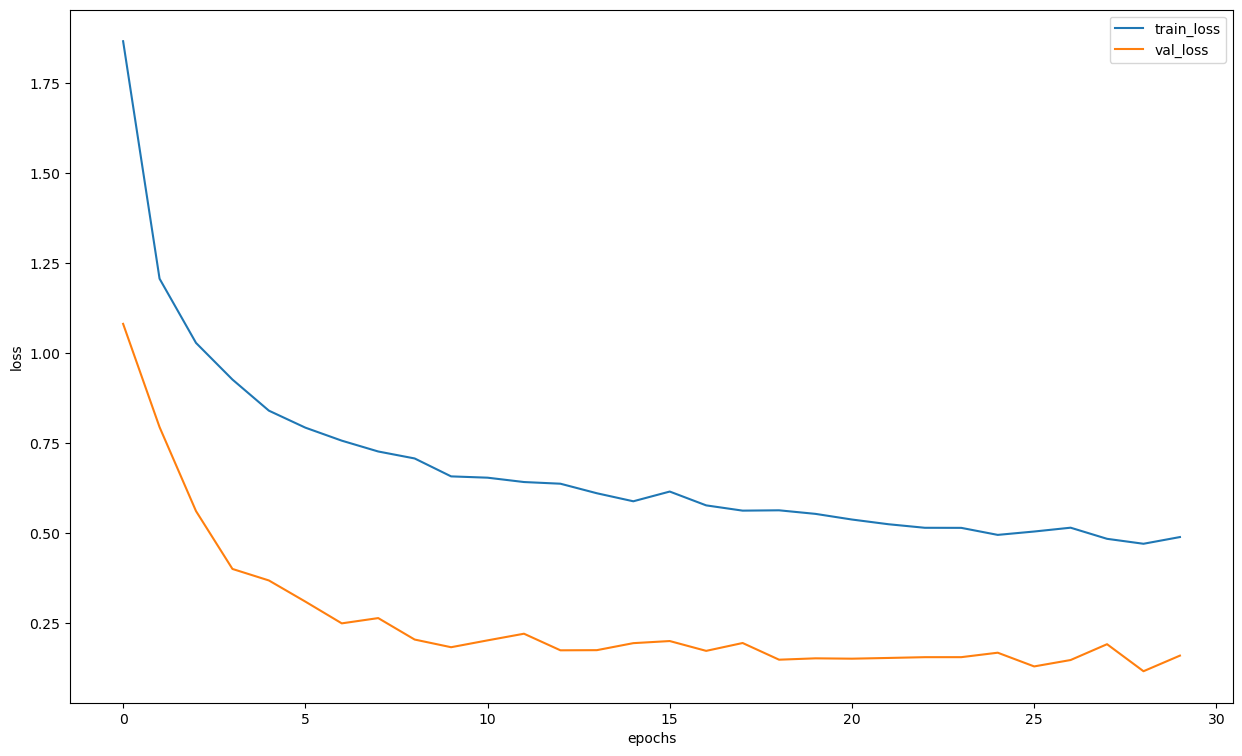

In [108]:
plt.figure(figsize=(15, 9))
plt.plot(loss_i, label="train_loss")
plt.plot(val_loss_i, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [110]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims_i = predict(model_inception, imgs)

In [111]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [112]:
y_pred_i = np.argmax(probs_ims_i,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred_i]

Обратите внимание, что метрика, которую необходимо оптимизировать в конкурсе --- f1-score. Вычислим целевую метрику на валидационной выборке.

In [113]:
f1_i = f1_score(actual_labels, y_pred_i, average='micro')

print("F1-оценка:", f1_i)


F1-оценка: 1.0


Сделаем визуализацию,  чтобы посмотреть насколько сеть уверена в своих ответах. Можете исспользовать это, чтобы отлаживать правильность вывода.

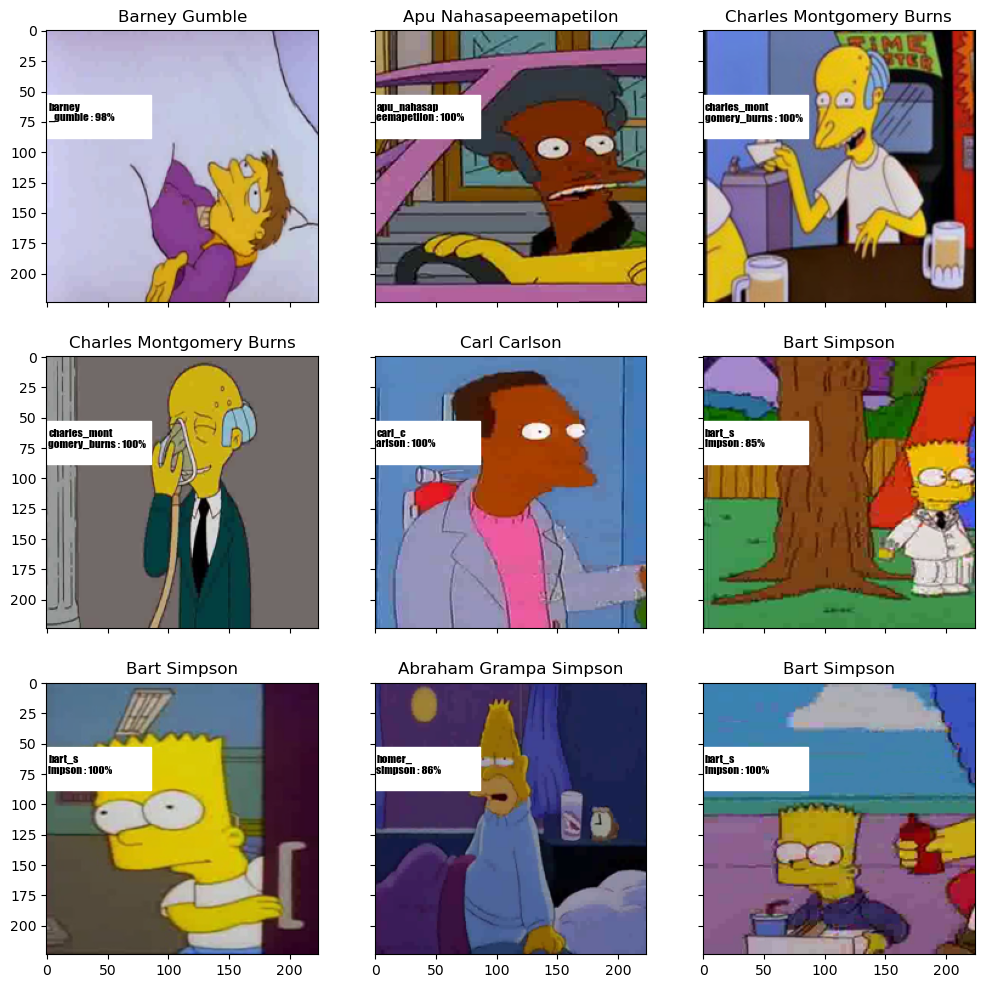

In [114]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))



    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

    actual_text = "Actual : {}".format(img_label)

    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred_inception = predict_one_sample(model_inception, im_val.unsqueeze(0))
    predicted_proba_inception = np.max(prob_pred_inception)*100
    y_pred_inception = np.argmax(prob_pred_inception)

    predicted_label_inception = label_encoder.classes_[y_pred_inception]
    predicted_label_inception = predicted_label_inception[:len(predicted_label_inception)//2] + '\n' + predicted_label_inception[len(predicted_label_inception)//2:]
    predicted_text_inception = "{} : {:.0f}%".format(predicted_label_inception,predicted_proba_inception)

    fig_x.text(1, 59, predicted_text_inception , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

In [115]:
tprint(f"Предсказания сделаны, F1 = {f1_i}")

Предсказания сделаны, F1 = 1.0


<B>Промежуточный итог</B>: На данной выборке получен результат <B>0.9628</B> (поменьше чем на ResNet152 выше) на тестовой выборке

&nbsp;

#### Inception. Подготовка файла Submission

In [116]:
model_inception.load_state_dict(torch.load(f"./models/inceptionv4__acc0.9761176920137562_cu_learn_epoch29.pth"))

<All keys matched successfully>

In [117]:
test_dataset = SimpsonsDataset(test_files, mode="test",image_size=299)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs_inception = predict(model_inception, test_loader)


preds_inception = label_encoder.inverse_transform(np.argmax(probs_inception, axis=1))
test_filenames = [path.name for path in test_dataset.files]


In [119]:
# TODO : сделайте сабмит (это важно, если Вы не справляетесь, но дошли до этой ячейки, то сообщите в чат и Вам помогут)

In [120]:
submit_inception = pd.DataFrame(preds_inception)
submit_inception['Id'] = test_filenames
submit_inception = submit_inception.rename(columns={0:'Expected'})

In [122]:
submit_inception.to_csv("./submit_inception.csv", index=False)

In [123]:
#my_submit.to_csv('./simple_cnn_baseline.csv', index=False)

In [124]:
tprint(f"Выгружено: Inception")

Выгружено: Inception


&nbsp;

### Inception. Дообучение на полном датасете (train+val)

Также попопробуем добавить информацию из валидационной выборки для дообучения

In [ ]:
#resnet.load_state_dict(resnet_base_state_dict)

In [125]:
inception_base_state_dict = model_inception.state_dict() # сохранение чекпойнта


In [128]:
full_batch_size = 96
full_epochs = 3

In [129]:
full_dataset_inception = SimpsonsDataset(train_val_files, mode='train',image_size=299)

In [130]:
train_fullset(files=full_dataset_inception, 
              model=model_inception, 
              epochs=full_epochs, 
              batch_size=full_batch_size,
              device=DEVICE,
              save_model=False,
              savename='model') 

epoch:  33%|█████████████████████████                                                  | 1/3 [20:22<40:44, 1222.24s/it]


Epoch 001 loss: 0.4816 acc 0.8722 


epoch:  67%|██████████████████████████████████████████████████                         | 2/3 [40:46<20:23, 1223.18s/it]


Epoch 002 loss: 0.4560 acc 0.8768 


epoch: 100%|█████████████████████████████████████████████████████████████████████████| 3/3 [1:00:49<00:00, 1216.45s/it]


Epoch 003 loss: 0.4643 acc 0.8757 


In [131]:
tprint('ready for submission')

ready for submission


In [139]:
make_submission(model_inception,test_files,"./submission_inception_fullset.csv",image_size=299)

Submission saved to file ././submission_inception_fullset.csv


In [140]:
tprint('submission ready')

submission ready


<B>Промежуточный итог</B>: На данной выборке получен результат <B>0.9543</B> (ещё меньше) на тестовой выборке.

&nbsp;

## Вывод:

Лучший результат (<B>0.98937</B>) на тестовой выборке получен с помощью модели ResNet152, обученной на 40 эпохах с аугментациями:
- горизонтальное отражение с вероятностью 0.5
- удаление случайной области с вероятностью 0.5 (размер области от 0.02 до 0.33 от размера изображения
- размытие с ядром 55 с вероятностью 0.3 
- случайные афинные преобразования (поворот 140 градусов в обе стороны, смещение на 10% в обе стороны, изменение масштаба до 30% в сторону увеличения либо уменьшения, с вероятностью 0.4

&nbsp;

&nbsp;Сергей_Варивода_566381277

&nbsp;